In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pylab as plt
from jupyterthemes import jtplot
import numpy as np
import time
from scipy.optimize import curve_fit
import datetime

jtplot.style(theme='onedork')
# plt.rcParams['figure.figsize'] = (6.0, 6.0)

In [2]:
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
# url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url, index_col=[0,1]).swaplevel(1,0)
df

Lat        Long  1/22/20  \
Country/Region        Province/State                                          
Afghanistan           NaN                    33.000000   65.000000        0   
Albania               NaN                    41.153300   20.168300        0   
Algeria               NaN                    28.033900    1.659600        0   
Andorra               NaN                    42.506300    1.521800        0   
Angola                NaN                   -11.202700   17.873900        0   
...                                                ...         ...      ...   
Saint Kitts and Nevis NaN                    17.357822  -62.782998        0   
Canada                Northwest Territories  64.825500 -124.845700        0   
                      Yukon                  64.282300 -135.000000        0   
Kosovo                NaN                    42.602636   20.902977        0   
Burma                 NaN                    21.916200   95.956000        0   

                                             1/23/20  1/24/20  1/25/20  \
Country/Region        Province/State                                     
Afghanistan           NaN                          0        0        0   
Albania               NaN                          0        0        0   
Algeria               NaN                          0        0        0   
Andorra               NaN                          0        0        0   
Angola                NaN                          0        0        0   
...                                              ...      ...      ...   
Saint Kitts and Nevis NaN                          0        0        0   
Canada                Northwest Territories        0        0        0   
                      Yukon                        0        0        0   
Kosovo                NaN                          0        0        0   
Burma                 NaN                          0        0        0   

                                             1/26/20  1/27/20  1/28/20  \
Country/Region        Province/State                                     
Afghanistan           NaN                          0        0        0   
Albania               NaN                          0        0        0   
Algeria               NaN                          0        0        0   
Andorra               NaN                          0        0        0   
Angola                NaN                          0        0        0   
...                                              ...      ...      ...   
Saint Kitts and Nevis NaN                          0        0        0   
Canada                Northwest Territories        0        0        0   
                      Yukon                        0        0        0   
Kosovo                NaN                          0        0        0   
Burma                 NaN                          0        0        0   

                                             1/29/20  ...  3/18/20  3/19/20  \
Country/Region        Province/State                  ...                     
Afghanistan           NaN                          0  ...        0        0   
Albania               NaN                          0  ...        2        2   
Algeria               NaN                          0  ...        7        9   
Andorra               NaN                          0  ...        0        0   
Angola                NaN                          0  ...        0        0   
...                                              ...  ...      ...      ...   
Saint Kitts and Nevis NaN                          0  ...        0        0   
Canada                Northwest Territories        0  ...        0        0   
                      Yukon                        0  ...        0        0   
Kosovo                NaN                          0  ...        0        0   
Burma                 NaN                          0  ...        0        0   

                                             3/20/20  3/21/20  3/22/2

In [3]:
df = df.drop(['Lat', 'Long'], 1).T

In [4]:
df.index = pd.to_datetime(df.index)

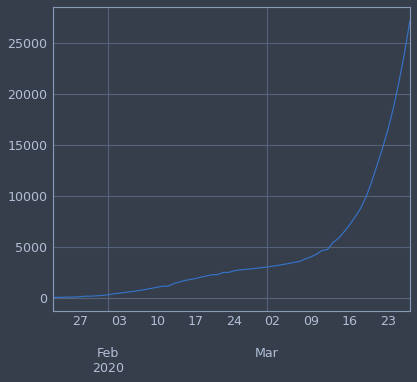

In [5]:
df.T.sum().plot()

In [6]:
len(df.columns)

249

In [7]:
df_exchina = df.drop('China', 1)
df_exchina = df_exchina[df_exchina.T.sum() > 1]
len(df_exchina.columns)

/usr/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


216

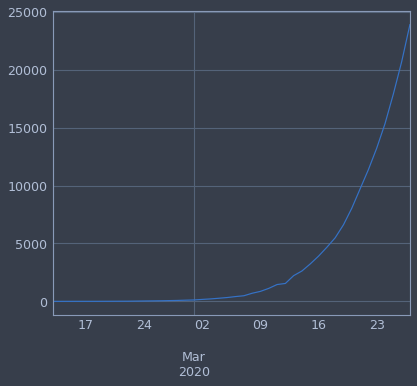

In [8]:
df_exchina.T.sum().plot()

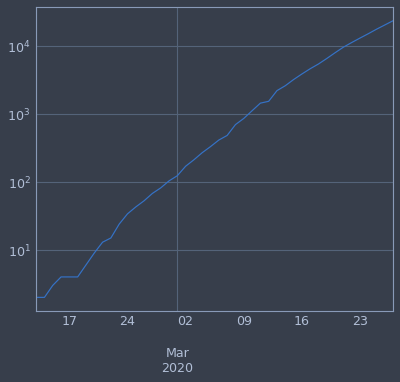

In [9]:
df_exchina.T.sum().plot(logy = True)

In [10]:
def sigmoid(x, sat, td, velo):
    x = np.float64(x)
    
    td *= 1e10
    td *= 1e9
    
    real_sat = 1e5 * sat
    x = x - td
    x /= 1e14
    return real_sat / (1 + np.exp(-x * velo))

x = df_exchina.index
sat = 30000 / 1e5
td = time.time() / 1e10
velo = .1

In [11]:
popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_exchina.index, 
                       ydata = df_exchina.T.sum(), 
                       p0 = (sat, td, velo)
                      )

In [12]:
y_fit = sigmoid(x, *list(popt))

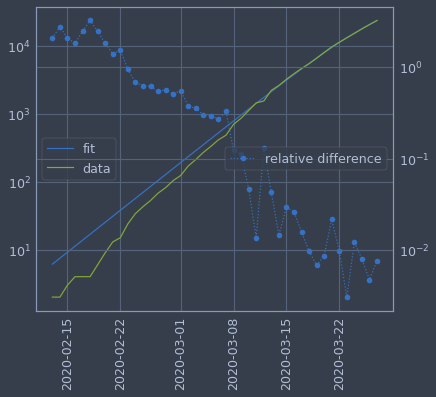

In [13]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=90)


ax1.semilogy(x, y_fit, label="fit")
ax1.semilogy(x, df_exchina.T.sum(), label="data")

ax2 = ax1.twinx()
ax2.semilogy(x, abs(y_fit - df_exchina.T.sum())/df_exchina.T.sum(), "o:", label="relative difference")
# ax1.legend(loc="lower left")
# ax2.legend(loc="center left")
ax1.legend(loc="center left")
ax2.legend(loc="center right")

In [14]:
th = datetime.datetime.fromtimestamp(popt[1] * 1e10)

In [15]:
f'The total number of Deaths outside China due to Covid-19 will be {int(popt[0] * 1e5)}. Half of those will be reached at {th.strftime("%Y-%B-%d %H:%M")}'

'The total number of Deaths outside China due to Covid-19 will be 63871. Half of those will be reached at 2020-March-29 16:16'

In [16]:
tstart = min(df_exchina.index)
tend = tstart + (th - tstart) * 2

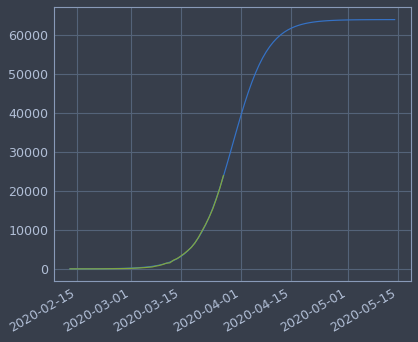

In [17]:
x_extra = np.arange(tstart, tend, datetime.timedelta(days=1)).astype('datetime64[ns]')
y_extra = sigmoid(x_extra, *list(popt))

plt.plot(x_extra, y_extra)
df_exchina.T.sum().plot()
plt.show()

In [18]:
df_exchina["Italy"].T.sum().diff()#.plot(logy=False)

2020-02-13      NaN
2020-02-14      0.0
2020-02-15      0.0
2020-02-16      0.0
2020-02-17      0.0
2020-02-18      0.0
2020-02-19      0.0
2020-02-20      0.0
2020-02-21      1.0
2020-02-22      1.0
2020-02-23      1.0
2020-02-24      4.0
2020-02-25      3.0
2020-02-26      2.0
2020-02-27      5.0
2020-02-28      4.0
2020-02-29      8.0
2020-03-01      5.0
2020-03-02     18.0
2020-03-03     27.0
2020-03-04     28.0
2020-03-05     41.0
2020-03-06     49.0
2020-03-07     36.0
2020-03-08    133.0
2020-03-09     97.0
2020-03-10    168.0
2020-03-11    196.0
2020-03-12      0.0
2020-03-13    439.0
2020-03-14    175.0
2020-03-15    368.0
2020-03-16    349.0
2020-03-17    345.0
2020-03-18    475.0
2020-03-19    427.0
2020-03-20    627.0
2020-03-21    793.0
2020-03-22    651.0
2020-03-23    601.0
2020-03-24    743.0
2020-03-25    683.0
2020-03-26    712.0
2020-03-27    919.0
dtype: float64

In [19]:
df_exchina.T.sum().diff()

2020-02-13       NaN
2020-02-14       0.0
2020-02-15       1.0
2020-02-16       1.0
2020-02-17       0.0
2020-02-18       0.0
2020-02-19       2.0
2020-02-20       3.0
2020-02-21       4.0
2020-02-22       2.0
2020-02-23       9.0
2020-02-24      10.0
2020-02-25       9.0
2020-02-26      10.0
2020-02-27      15.0
2020-02-28      14.0
2020-02-29      22.0
2020-03-01      20.0
2020-03-02      47.0
2020-03-03      42.0
2020-03-04      58.0
2020-03-05      62.0
2020-03-06      83.0
2020-03-07      70.0
2020-03-08     216.0
2020-03-09     163.0
2020-03-10     258.0
2020-03-11     331.0
2020-03-12      94.0
2020-03-13     676.0
2020-03-14     402.0
2020-03-15     611.0
2020-03-16     672.0
2020-03-17     766.0
2020-03-18     817.0
2020-03-19    1126.0
2020-03-20    1428.0
2020-03-21    1668.0
2020-03-22    1663.0
2020-03-23    1854.0
2020-03-24    2113.0
2020-03-25    2552.0
2020-03-26    2783.0
2020-03-27    3223.0
dtype: float64

In [20]:
x = []
y_var = []
y = []

for e in df_exchina.index[30:]:
    df_temp = df_exchina[:e]
    
    popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_temp.index, 
                       ydata = df_temp.T.sum(), 
                       p0 = (sat, td, velo)
                      )
    
    x.append(e + datetime.timedelta(days=2))
    y_var.append(np.diag(pcov)[1] * 1e10)
    y.append(datetime.datetime.fromtimestamp(popt[1] * 1e10))
    

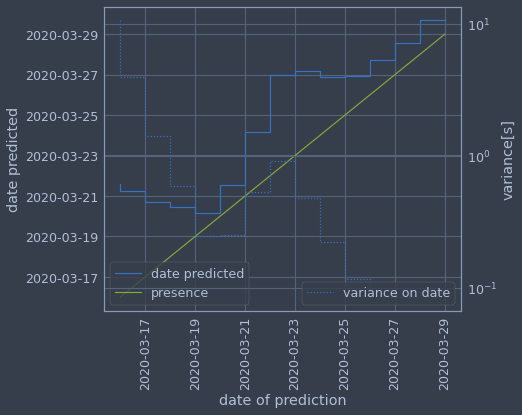

In [21]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=90)
plt.xlabel("date of prediction")

plt.ylabel("date predicted")

ax1.plot(x, y, label='date predicted', drawstyle='steps')
ax1.plot(x, x, label='presence')


ax2 = ax1.twinx()
ax2.semilogy(x, y_var, ":", label='variance on date', drawstyle='steps')
plt.ylabel("variance[s]")

ax1.legend(loc="lower left")
ax2.legend(loc="lower right")